# EMD Framework Analysis

Generate chirp signal with amplitude modulation and apply EMD decomposition.
Extracts Intrinsic Mode Functions (IMFs) via iterative local median fitting.

**Signal:** $y(x) = \{1 + 0.5\sin(4\pi x)\} \cdot \sin(2\pi(6x + 12x^2)) + 0.2\varepsilon(x)$

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'

## EMD Framework Implementation

In [16]:
def epanechnikov_kernel(u: np.ndarray) -> np.ndarray:
    """
    Epanechnikov kernel: K(u) = 0.75 * (1 - u²) for |u| <= 1
    """
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0.0)


def kernel_weights(t: int, n: int, h: float) -> np.ndarray:
    """
    Compute kernel weights K_h(s - t) for all s in [0, n-1].
    K_h(u) = (1/h) * K(u/h)
    """
    s = np.arange(n)
    u = (s - t) / n  # Normalize to [0, 1] scale
    weights = epanechnikov_kernel(u / h) / h
    return weights


def weighted_median(x: np.ndarray, weights: np.ndarray) -> float:
    """
    Compute weighted median: argmin_m sum_s |X_s - m| * w_s
    """
    mask = weights > 0
    if not np.any(mask):
        return np.nan
    
    x_filtered = x[mask]
    w_filtered = weights[mask]
    
    sorted_indices = np.argsort(x_filtered)
    x_sorted = x_filtered[sorted_indices]
    w_sorted = w_filtered[sorted_indices]
    
    cumsum = np.cumsum(w_sorted)
    median_idx = np.searchsorted(cumsum, cumsum[-1] / 2)
    
    return x_sorted[median_idx]


def local_median_fit(x: np.ndarray, h: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute local median fit for the entire series.
    """
    n = len(x)
    x_tilde = np.full(n, np.nan)
    
    t_min = int(np.ceil(h * n))
    t_max = int(np.floor((1 - h) * n))
    
    for t in range(t_min, t_max + 1):
        weights = kernel_weights(t, n, h)
        x_tilde[t] = weighted_median(x, weights)
    
    valid_mask = ~np.isnan(x_tilde)
    return x_tilde, valid_mask


def emd_decomposition(
    x: np.ndarray,
    h_init: float = 0.1,
    a: float = np.sqrt(2),
    h_min: float = 0.01,
    k_max: int = 10
) -> dict:
    """
    Empirical Mode Decomposition via iterative local median fitting.
    Extracts Intrinsic Mode Functions (IMFs).
    """
    n = len(x)
    residual = x.copy()
    imfs = []
    bandwidths = []
    combined_valid_mask = np.ones(n, dtype=bool)
    
    h_k = h_init
    
    for k in range(k_max):
        if h_k < h_min:
            break
            
        x_tilde_k, valid_mask = local_median_fit(residual, h_k)
        combined_valid_mask &= valid_mask
        
        imfs.append(x_tilde_k.copy())
        bandwidths.append(h_k)
        
        residual = np.where(valid_mask, residual - x_tilde_k, residual)
        h_k = h_k / a
    
    reconstruction = np.zeros(n)
    for imf in imfs:
        reconstruction = np.where(~np.isnan(imf), reconstruction + imf, reconstruction)
    
    return {
        'imfs': imfs,
        'residual': residual,
        'reconstruction': reconstruction,
        'bandwidths': bandwidths,
        'valid_mask': combined_valid_mask,
        'n_iterations': len(imfs)
    }

## Generate Signal

In [17]:
def generate_signal(n: int = 2000, seed: int = 42) -> Tuple[np.ndarray, np.ndarray, dict]:
    """
    Generate the chirp signal with amplitude modulation:
    
    y(x) = {1 + 0.5*sin(4πx)} * sin(2π(6x + 12x²)) + 0.2*ε(x)
    """
    np.random.seed(seed)
    
    # Time points in (0, 1)
    x = np.linspace(0, 1, n, endpoint=False)[1:]  # Exclude 0
    n = len(x)
    
    # Amplitude modulation: A(x) = 1 + 0.5*sin(4πx)
    amplitude = 1 + 0.5 * np.sin(4 * np.pi * x)
    
    # Frequency-modulated carrier (chirp): sin(2π(6x + 12x²))
    phase = 2 * np.pi * (6 * x + 12 * x**2)
    carrier = np.sin(phase)
    
    # Clean signal (AM-FM)
    clean_signal = amplitude * carrier
    
    # Noise: 0.2 * ε(x) where ε ~ N(0,1)
    noise = 0.2 * np.random.randn(n)
    
    # Full signal
    y = clean_signal + noise
    
    components = {
        'amplitude': amplitude,
        'carrier': carrier,
        'clean_signal': clean_signal,
        'noise': noise
    }
    
    return x, y, components


# Generate signal
x, y, components = generate_signal(n=2000, seed=42)
n = len(x)

print(f"Generated {n} samples")
print(f"Signal range: [{y.min():.3f}, {y.max():.3f}]")
print(f"Instantaneous frequency range: [{6 + 24*x[0]:.1f}, {6 + 24*x[-1]:.1f}] Hz")

Generated 1999 samples
Signal range: [-1.770, 2.001]
Instantaneous frequency range: [6.0, 30.0] Hz


## Apply EMD Decomposition

In [18]:
result = emd_decomposition(
    y,
    h_init=0.1,
    a=np.sqrt(2),
    h_min=0.005,
    k_max=12
)

print(f"Number of IMFs extracted: {result['n_iterations']}")
print(f"Bandwidths: {[f'{h:.4f}' for h in result['bandwidths']]}")
print(f"Valid reconstruction range: {result['valid_mask'].sum()} / {n} points")

Number of IMFs extracted: 9
Bandwidths: ['0.1000', '0.0707', '0.0500', '0.0354', '0.0250', '0.0177', '0.0125', '0.0088', '0.0062']
Valid reconstruction range: 1600 / 1999 points


## Figure 1: Signal and its Components

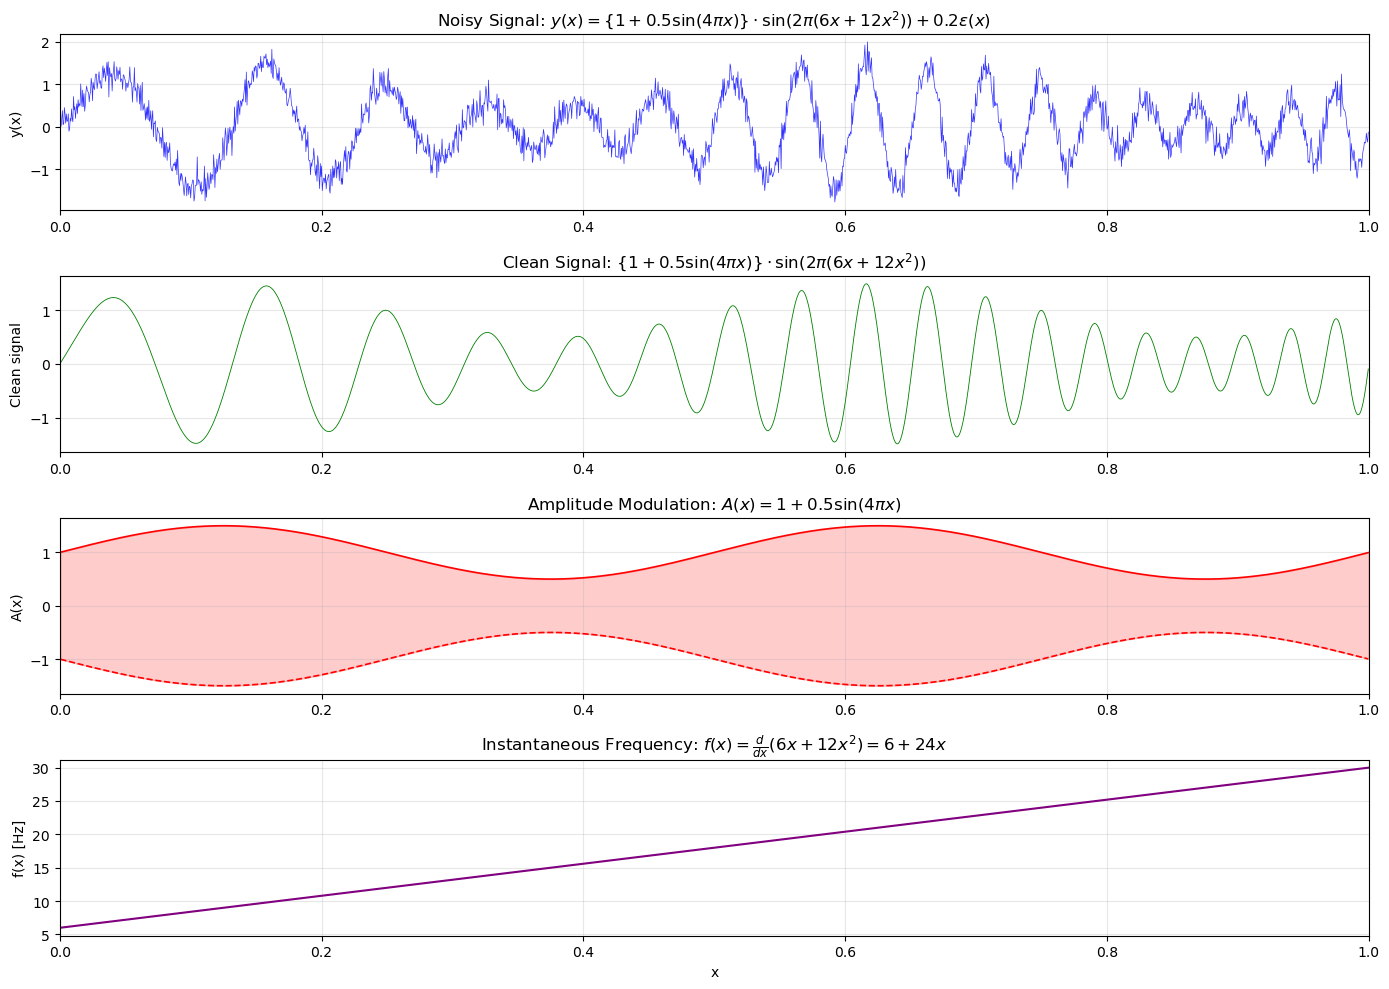

In [19]:
fig1, axes1 = plt.subplots(4, 1, figsize=(14, 10))

# Original noisy signal
axes1[0].plot(x, y, 'b-', lw=0.5, alpha=0.8)
axes1[0].set_ylabel('y(x)')
axes1[0].set_title(r'Noisy Signal: $y(x) = \{1 + 0.5\sin(4\pi x)\} \cdot \sin(2\pi(6x + 12x^2)) + 0.2\varepsilon(x)$', 
                   fontsize=12)
axes1[0].set_xlim([0, 1])
axes1[0].grid(True, alpha=0.3)

# Clean signal
axes1[1].plot(x, components['clean_signal'], 'g-', lw=0.6)
axes1[1].set_ylabel('Clean signal')
axes1[1].set_title(r'Clean Signal: $\{1 + 0.5\sin(4\pi x)\} \cdot \sin(2\pi(6x + 12x^2))$', fontsize=12)
axes1[1].set_xlim([0, 1])
axes1[1].grid(True, alpha=0.3)

# Amplitude envelope
axes1[2].plot(x, components['amplitude'], 'r-', lw=1.2, label='Amplitude envelope')
axes1[2].plot(x, -components['amplitude'], 'r--', lw=1.2)
axes1[2].fill_between(x, -components['amplitude'], components['amplitude'], alpha=0.2, color='red')
axes1[2].set_ylabel('A(x)')
axes1[2].set_title(r'Amplitude Modulation: $A(x) = 1 + 0.5\sin(4\pi x)$', fontsize=12)
axes1[2].set_xlim([0, 1])
axes1[2].grid(True, alpha=0.3)

# Instantaneous frequency
inst_freq = 6 + 24 * x
axes1[3].plot(x, inst_freq, 'purple', lw=1.5)
axes1[3].set_ylabel('f(x) [Hz]')
axes1[3].set_xlabel('x')
axes1[3].set_title(r'Instantaneous Frequency: $f(x) = \frac{d}{dx}(6x + 12x^2) = 6 + 24x$', fontsize=12)
axes1[3].set_xlim([0, 1])
axes1[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Figure 2: EMD Decomposition Results (IMFs)

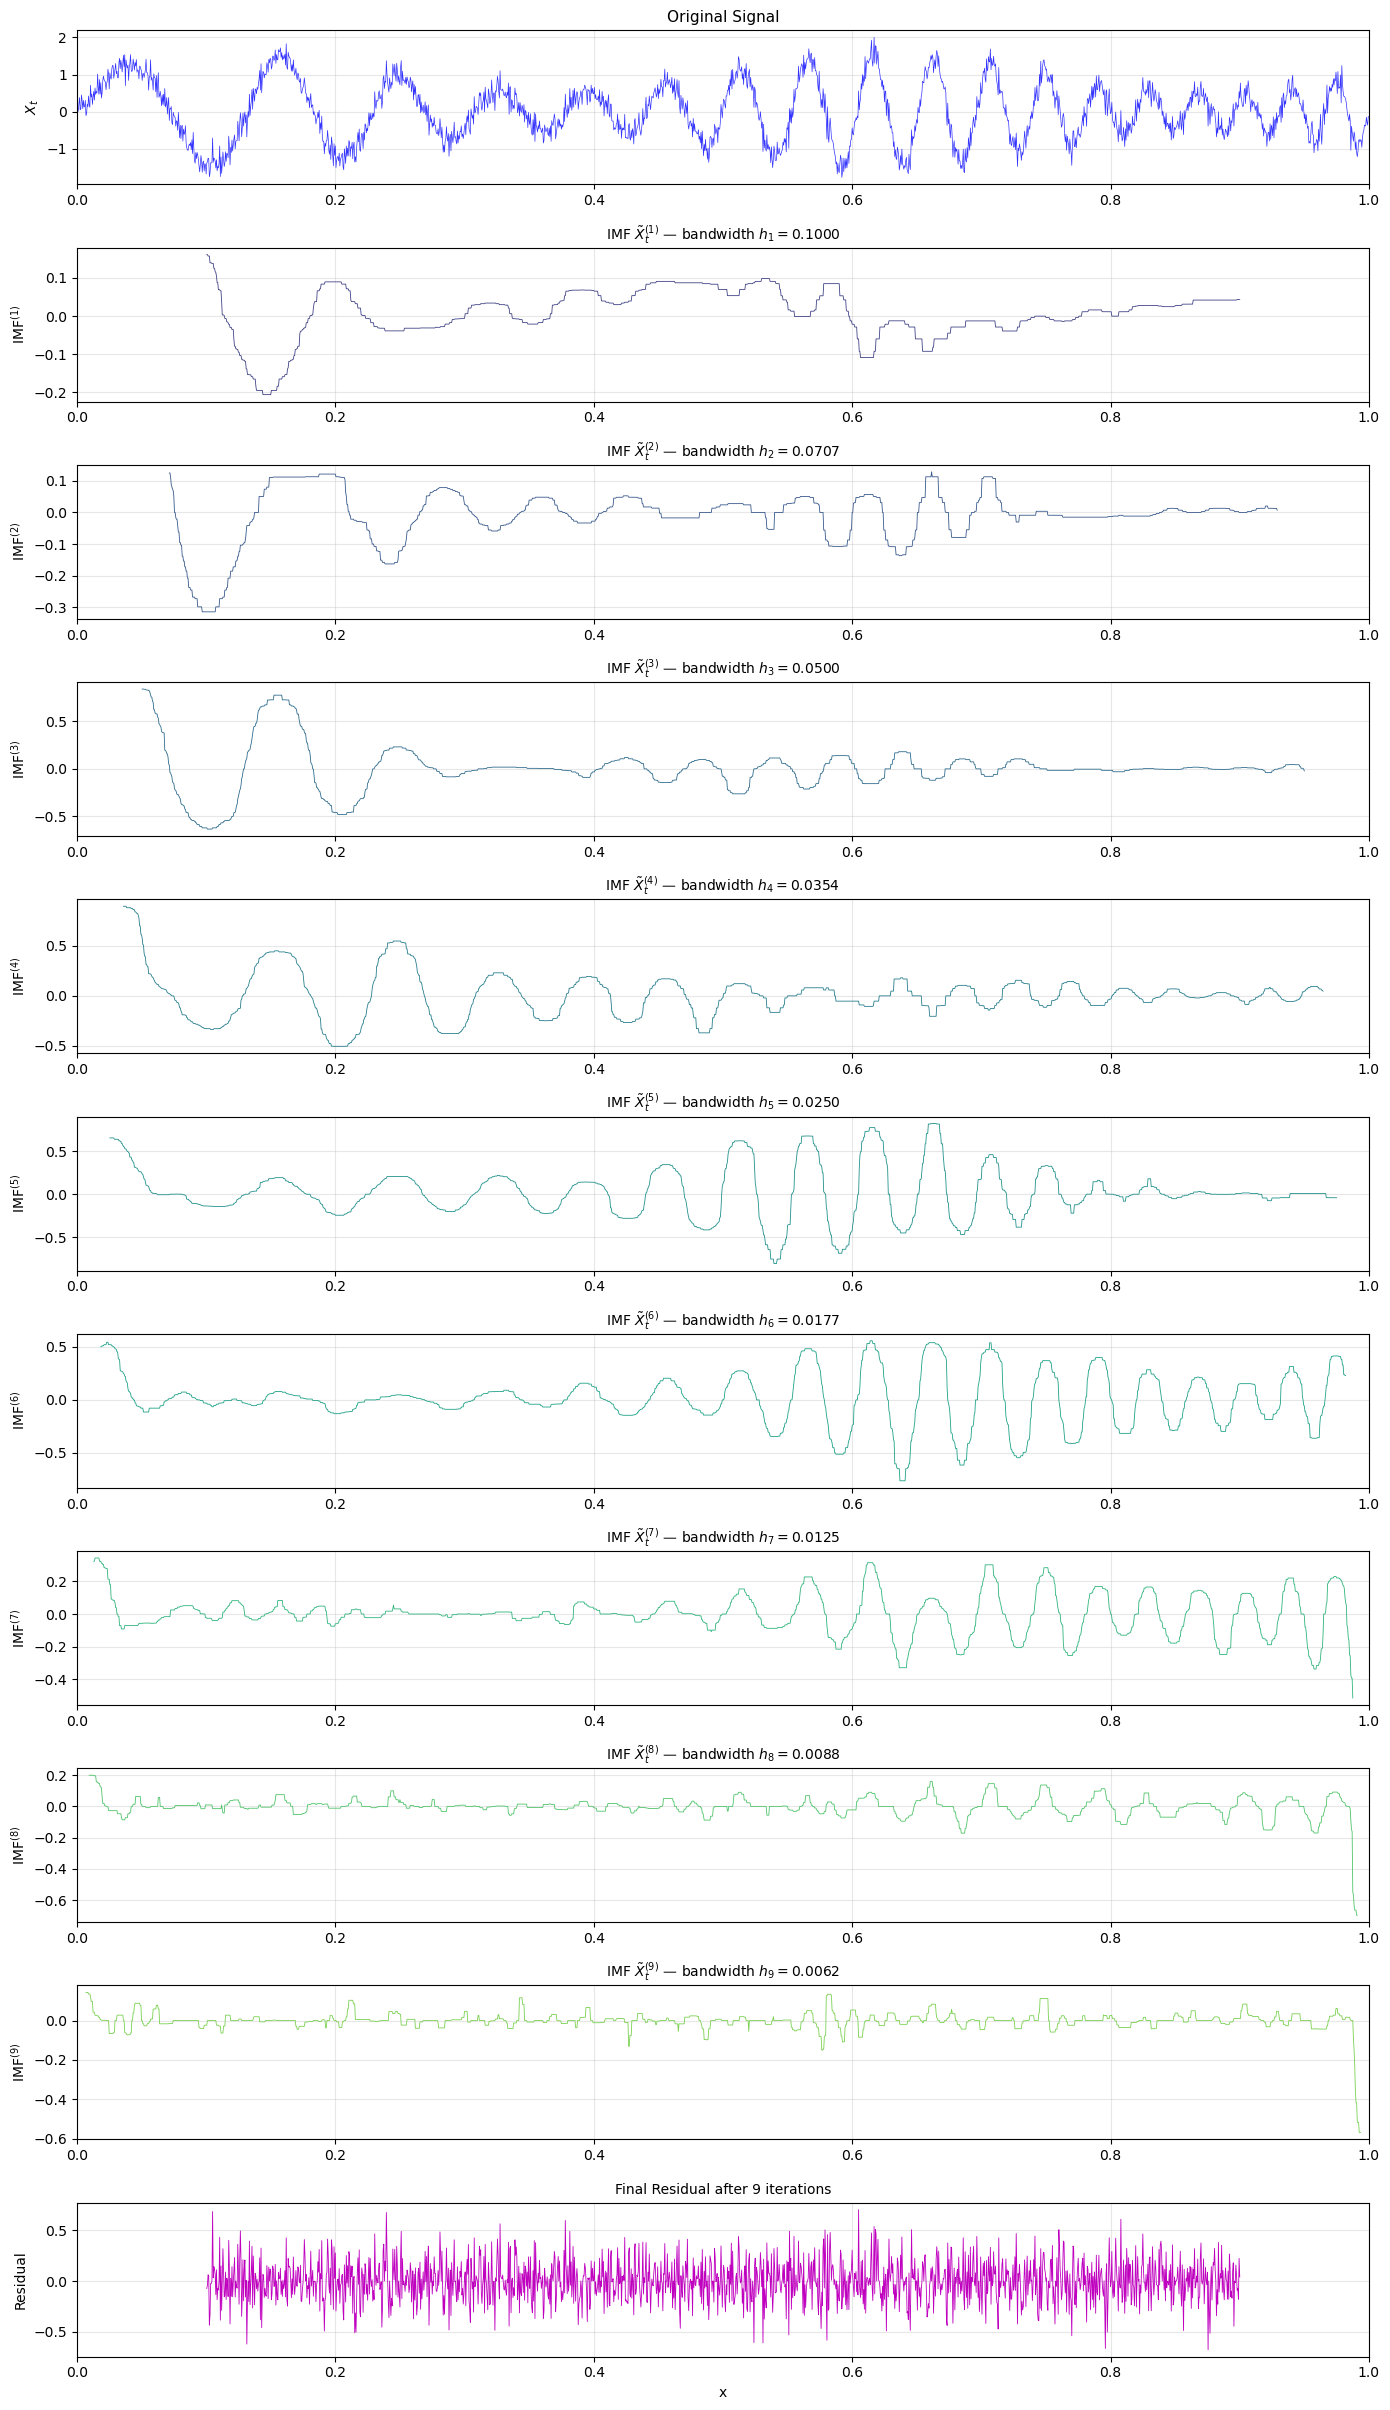

In [20]:
n_imfs = result['n_iterations']
fig2, axes2 = plt.subplots(n_imfs + 2, 1, figsize=(14, 2.2 * (n_imfs + 2)))

# Original signal
axes2[0].plot(x, y, 'b-', lw=0.5, alpha=0.8)
axes2[0].set_ylabel('$X_t$')
axes2[0].set_title('Original Signal', fontsize=11)
axes2[0].set_xlim([0, 1])
axes2[0].grid(True, alpha=0.3)

# IMFs
colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_imfs))
for k, imf in enumerate(result['imfs']):
    ax = axes2[k + 1]
    valid = ~np.isnan(imf)
    ax.plot(x[valid], imf[valid], color=colors[k], lw=0.6)
    ax.set_ylabel(f'IMF$^{{({k+1})}}$')
    ax.set_title(f'IMF $\\tilde{{X}}_t^{{({k+1})}}$ — bandwidth $h_{{{k+1}}} = {result["bandwidths"][k]:.4f}$', 
                 fontsize=10)
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3)

# Final residual
valid = result['valid_mask']
axes2[-1].plot(x[valid], result['residual'][valid], 'm-', lw=0.6)
axes2[-1].set_ylabel('Residual')
axes2[-1].set_xlabel('x')
axes2[-1].set_title(f'Final Residual after {n_imfs} iterations', fontsize=10)
axes2[-1].set_xlim([0, 1])
axes2[-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Figure 3: Reconstruction Quality

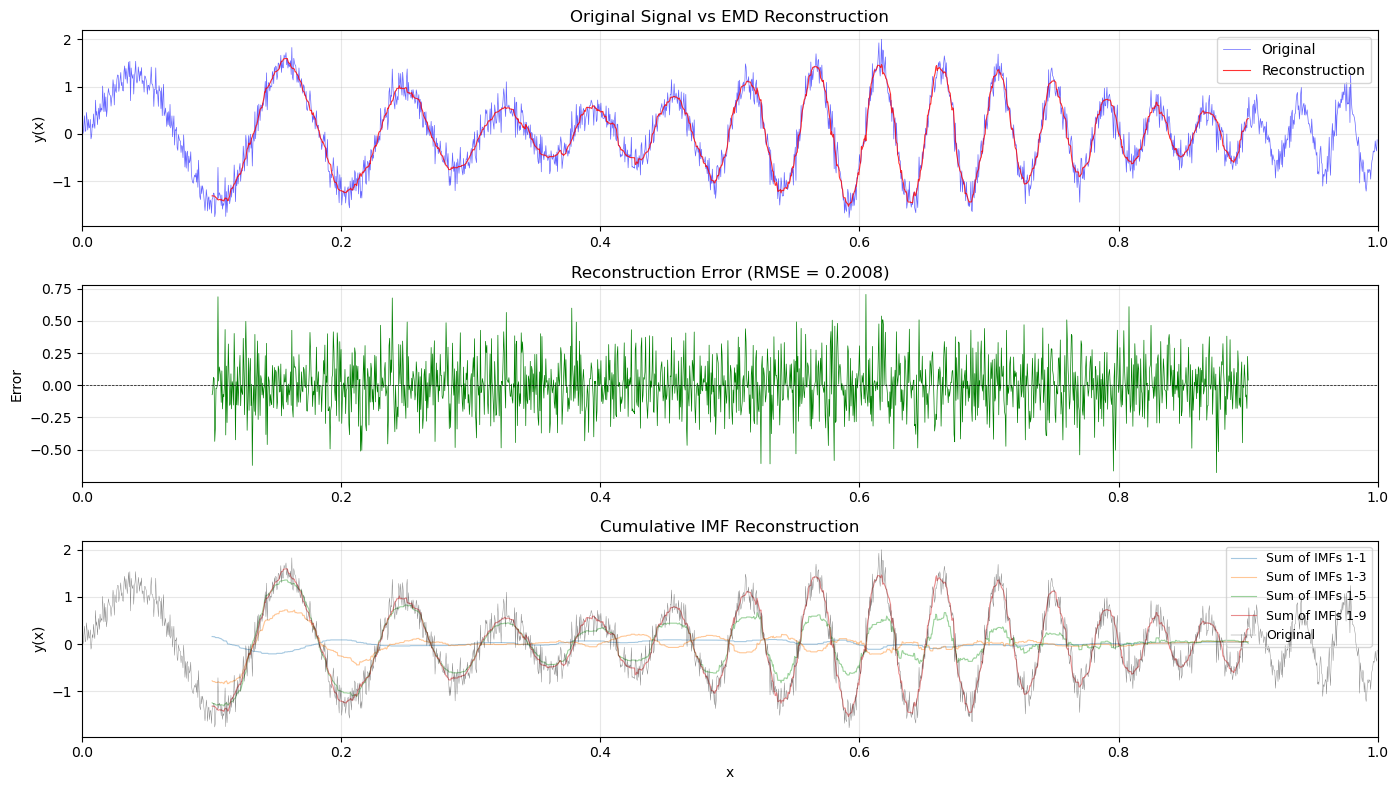

In [21]:
fig3, axes3 = plt.subplots(3, 1, figsize=(14, 8))

valid = result['valid_mask']

# Original vs Reconstruction
axes3[0].plot(x, y, 'b-', lw=0.5, alpha=0.6, label='Original')
axes3[0].plot(x[valid], result['reconstruction'][valid], 'r-', lw=0.8, alpha=0.8, label='Reconstruction')
axes3[0].set_ylabel('y(x)')
axes3[0].set_title('Original Signal vs EMD Reconstruction', fontsize=12)
axes3[0].legend(loc='upper right')
axes3[0].set_xlim([0, 1])
axes3[0].grid(True, alpha=0.3)

# Reconstruction error
error = np.full(n, np.nan)
error[valid] = y[valid] - result['reconstruction'][valid]
axes3[1].plot(x[valid], error[valid], 'g-', lw=0.5)
axes3[1].axhline(0, color='k', ls='--', lw=0.5)
axes3[1].set_ylabel('Error')
axes3[1].set_title(f'Reconstruction Error (RMSE = {np.nanstd(error):.4f})', fontsize=12)
axes3[1].set_xlim([0, 1])
axes3[1].grid(True, alpha=0.3)

# Cumulative reconstruction
cumulative = np.zeros(n)
n_imfs = len(result['imfs'])
for k, imf in enumerate(result['imfs']):
    cumulative = np.where(~np.isnan(imf), cumulative + imf, cumulative)
    if k in [0, 2, 4, n_imfs-1]:
        label = f'Sum of IMFs 1-{k+1}'
        alpha = 0.4 + 0.15 * k / n_imfs
        axes3[2].plot(x[valid], cumulative[valid], lw=0.8, alpha=alpha, label=label)

axes3[2].plot(x, y, 'k-', lw=0.3, alpha=0.5, label='Original')
axes3[2].set_ylabel('y(x)')
axes3[2].set_xlabel('x')
axes3[2].set_title('Cumulative IMF Reconstruction', fontsize=12)
axes3[2].legend(loc='upper right', fontsize=9)
axes3[2].set_xlim([0, 1])
axes3[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()